## Importing online financial data in JSON format

In [ ]:
from urllib.request import urlopen
import json
import time
import pandas as pd


def get_bigmac_codes():
    """Get a Pandas DataFrame of all codes in the Big Mac index dataset

    The first column contains the code, while the second header
    contains the description of the code.
    
    E.g. 
    ECONOMIST/BIGMAC_ARG,Big Mac Index - Argentina
    ECONOMIST/BIGMAC_AUS,Big Mac Index - Australia
    ECONOMIST/BIGMAC_BRA,Big Mac Index - Brazil
    
    Returns:
        codes: Pandas DataFrame of Quandl dataset codes"""
    
    codes_url = "https://www.quandl.com/api/v3/databases/ECONOMIST/codes"
    codes = pd.read_csv(codes_url, header=None, names=['Code', 'Description'], 
                        compression='zip', encoding='latin_1')
    
    return codes

    
def get_quandl_dataset(api_key, code):
    """Obtain and parse a quandl dataset in Pandas DataFrame format

    Quandl returns dataset in JSON format, where data is stored as a 
    list of lists in response['dataset']['data'], and column headers
    stored in response['dataset']['column_names'].
    
    E.g. {'dataset': {...,
             'column_names': ['Date',
                              'local_price',
                              'dollar_ex',
                              'dollar_price',
                              'dollar_ppp',
                              'dollar_valuation',
                              'dollar_adj_valuation',
                              'euro_adj_valuation',
                              'sterling_adj_valuation',
                              'yen_adj_valuation',
                              'yuan_adj_valuation'],
             'data': [['2017-01-31',
                       55.0,
                       15.8575,
                       3.4683903515687,
                       10.869565217391,
                       -31.454736135007,
                       6.2671477203176,
                       8.2697553162259,
                       29.626894343348,
                       32.714616745128,
                       13.625825886047],
                      ['2016-07-31',
                       50.0,
                       14.935,
                       3.3478406427854,
                       9.9206349206349,
                       -33.574590420925,
                       2.0726096168216,
                       0.40224795003514,
                       17.56448458418,
                       19.76377270142,
                       11.643103380531]
                      ],
             'database_code': 'ECONOMIST',
             'dataset_code': 'BIGMAC_ARG',
             ... }}
    
    A custom column--country is added to denote the 3-letter country code.
    
    Args:
        api_key: Quandl API key
        code: Quandl dataset code

    Returns:
        df: Pandas DataFrame of a Quandl dataset

    """
    base_url = "https://www.quandl.com/api/v3/datasets/"
    url_suffix = ".json?api_key="

    # Fetch the JSON response 
    u = urlopen(base_url + code + url_suffix + api_key)
    response = json.loads(u.read().decode('utf-8'))
    
    # Format the response as Pandas Dataframe
    df = pd.DataFrame(response['dataset']['data'], columns=response['dataset']['column_names'])
    
    # Label the country code
    df['country'] = code[-3:]
    
    return df


quandl_dfs = []
codes = get_bigmac_codes()

# Replace this with your own API key
api_key = "" 

for code in codes.Code:
    # Get the DataFrame of a Quandl dataset
    df = get_quandl_dataset(api_key, code)
    
    # Store in a list
    quandl_dfs.append(df)
    
    # Prevents exceeding the API speed limit
    time.sleep(2)
    
    
# Concatenate the list of dataframes into a single one    
bigmac_df = pd.concat(quandl_dfs)
bigmac_df.head()

In [ ]:
import urllib
import json
import pandas as pd
import time
from urllib.request import urlopen


def get_gdp_dataset(api_key, country_code):
    """Obtain and parse a quandl GDP dataset in Pandas DataFrame format

    Quandl returns dataset in JSON format, where data is stored as a 
    list of lists in response['dataset']['data'], and column headers
    stored in response['dataset']['column_names'].
    
    Args:
        api_key: Quandl API key
        country_code: Three letter code to represent country

    Returns:
        df: Pandas DataFrame of a Quandl dataset

    """
    base_url = "https://www.quandl.com/api/v3/datasets/"
    url_suffix = ".json?api_key="
    
    # Compose the Quandl API dataset code to get GDP per capita (constant 2000 US$) dataset
    gdp_code = "WWDI/" + country_code + "_NY_GDP_PCAP_KD"
    
    # Parse the JSON response from Quandl API
    # Some countries might be missing, so we need error handling code
    try:
        u = urlopen(base_url + gdp_code + url_suffix + api_key)
    except urllib.error.URLError as e:
        print(gdp_code,e)
        return None
        
    response = json.loads(u.read().decode('utf-8'))
    
    # Format the response as Pandas Dataframe
    df = pd.DataFrame(response['dataset']['data'], columns=response['dataset']['column_names'])
    
    # Add a new country code column
    df['country'] = country_code
    
    return df


api_key = ""  #Change this to your own API key

quandl_dfs = []

# Loop through all unique country code values in the BigMac index DataFrame
for country_code in bigmac_df.country.unique():
    # Fetch the GDP dataset for the corresponding country 
    df = get_gdp_dataset(api_key, country_code)
    
    # Skip if the response is empty
    if df is None:
        continue
        
    # Store in a list DataFrames
    quandl_dfs.append(df)
    
    # Prevents exceeding the API speed limit
    time.sleep(2)
    
    
# Concatenate the list of DataFrames into a single one    
gdp_df = pd.concat(quandl_dfs)
gdp_df.head()

In [ ]:
merged_df = pd.merge(bigmac_df[(bigmac_df.Date == "2017-01-31")], gdp_df[(gdp_df.Date == "2016-12-31")], how='inner', on='country')
merged_df.head()

### Scatter plot in Seaborn

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# seaborn.regplot() returns a matplotlib.Axes object
ax = sns.regplot(x="Value", y="dollar_price", data=merged_df, fit_reg=False)
# We can modify the axes labels just like other ordinary
# Matplotlib objects
ax.set_xlabel("GDP per capita (constant 2000 US$)")
ax.set_ylabel("BigMac index (US$)")

plt.savefig("ch09_simple_scatter.png", dpi=300)
plt.show()

In [ ]:
sns.set(style="whitegrid")
ax = sns.regplot(x="Value", y="dollar_price", data=merged_df)
ax.set_xlabel("GDP per capita (constant 2000 US$)")
ax.set_ylabel("BigMac index (US$)")

# Label the country code for those who demonstrate extreme BigMac index
for row in merged_df.itertuples():
    if row.dollar_price >= 5 or row.dollar_price <= 2:
        ax.text(row.Value,row.dollar_price+0.1,row.country)

plt.savefig("ch09_scatter_labelled.png", dpi=300)
plt.show()

In [ ]:
from scipy.stats import linregress


ax = sns.regplot(x="Value", y="dollar_price", data=merged_df)
ax.set_xlabel("GDP per capita (constant 2000 US$)")
ax.set_ylabel("BigMac index (US$)")

# Calculate linear regression parameters
slope, intercept, r_value, p_value, std_err = linregress(merged_df.Value, merged_df.dollar_price)

colors = []
for row in merged_df.itertuples():
    if row.dollar_price > row.Value * slope + intercept:
        # Color markers as darkred if they are above the regression line
        color = "darkred"
    else:
        # Color markers as darkblue if they are below the regression line
        color = "darkblue"
    
    # Label the country code for those who demonstrate extreme BigMac index
    if row.dollar_price >= 5 or row.dollar_price <= 2:
        ax.text(row.Value,row.dollar_price+0.1,row.country)
        
    # Highlight the marker that corresponds to China
    if row.country == "CHN":
        t = ax.text(row.Value,row.dollar_price+0.1,row.country)
        color = "yellow"
    
    colors.append(color)

# Overlay another scatter plot on top with marker-specific color
ax.scatter(merged_df.Value, merged_df.dollar_price, c=colors)

# Label the r squared value and p value of the linear regression model.
# transform=ax.transAxes indicates that the coordinates are given relative to the axes bounding box, 
# with 0,0 being the lower left of the axes and 1,1 the upper right.
ax.text(0.1, 0.9, "$r^2={0:.3f}, p={1:.3e}$".format(r_value ** 2, p_value), transform=ax.transAxes)

plt.savefig("ch09_scatter_colored.png", dpi=300)
plt.show()

In [ ]:
# seaborn.jointplot() returns a seaborn.JointGrid object
g = sns.jointplot(x="Value", y="dollar_price", data=merged_df)

# Provide custom axes labels through accessing the underlying axes object
# We can get matplotlib.axes.Axes of the scatter plot by calling g.ax_joint
g.ax_joint.set_xlabel("GDP per capita (constant 2000 US$)")
g.ax_joint.set_ylabel("BigMac index (US$)")

# Set the title and adjust the margin
g.fig.suptitle("Relationship between GDP per capita and BigMac Index")
g.fig.subplots_adjust(top=0.9)
plt.savefig("ch09_jointplot_scatter.png", dpi=300)
plt.show()

# Scraping information from web sites

In [1]:
import requests
from bs4 import BeautifulSoup


# Specify the url
url = "https://www.bls.gov/emp/ep_table_001.htm"

# Query the website and get the html response
response = requests.get(url)

# Parse the returned html using BeautifulSoup
bs = BeautifulSoup(response.text)

# Select the table header by CSS selector
thead = bs.select("#bodytext > table > thead")[0]

# Select the table body by CSS selector
tbody = bs.select("#bodytext > table > tbody")[0]

# Make sure the code works
print(thead)

<thead>
<tr>
<th scope="col"><p align="center" valign="top"><strong>Educational attainment</strong></p></th>
<th scope="col"><p align="center" valign="top">Unemployment rate (%)</p></th>
<th scope="col"><p align="center" valign="top">Median usual weekly earnings ($)</p></th>
</tr>
</thead>


/Users/chishingyu/anaconda/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/chishingyu/anaconda/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [2]:
# Get the column names
headers = []

# Find all header columns in <thead> as specified by <th> html tags
for col in thead.find_all('th'):
    headers.append(col.text.strip())

# Dictionary of lists for storing parsed data
data = {header:[] for header in headers}

In [3]:
import pandas as pd


# Parse the rows in table body
for row in tbody.find_all('tr'):
    # Find all columns in a row as specified by <th> or <td> html tags
    cols = row.find_all(['th','td'])
    
    # enumerate() allows us to loop over an iterable, 
    # and return each item preceded by a counter
    for i, col in enumerate(cols):
        # Strip white space around the text
        value = col.text.strip()
        
        # Try to convert the columns to float, except the first column
        if i > 0:
            value = float(value.replace(',','')) # Remove all commas in string
        
        # Append the float number to the dict of lists
        data[headers[i]].append(value)

# Create a dataframe from the parsed dictionary
df = pd.DataFrame(data)

# Show an excerpt of parsed data
df.head()

,Educational attainment,Median usual weekly earnings ($),Unemployment rate (%)
0,Doctoral degree,1743.0,1.5
1,Professional degree,1836.0,1.5
2,Master's degree,1401.0,2.2
3,Bachelor's degree,1173.0,2.5
4,Associate's degree,836.0,3.4


In [ ]:
import matplotlib
matplotlib.use('SVG')   # Change to SVG backend
import matplotlib.pyplot as plt
import textwrap  # Standard library for text wraping


# Create a figure
fig, ax = plt.subplots(figsize=(6,7))

# Create a list of x ticks positions
ind = range(df.shape[0])

# Plot a bar chart of median usual weekly earnings by educational attainments
rects = ax.barh(ind, df["Median usual weekly earnings ($)"], height=0.5)

# Set the x-axis label
ax.set_xlabel('Median weekly earnings (USD)')

# Label the x ticks
# The tick labels are a bit too long, let's wrap them in 15-char lines
ylabels=[textwrap.fill(label,15) for label in df["Educational attainment"]]
ax.set_yticks(ind)
ax.set_yticklabels(ylabels)

# Give extra margin at the bottom to display the tick labels
fig.subplots_adjust(left=0.3)

# Save the figure in SVG format
plt.savefig("ch09_svg.png", dpi=300)

# Interactive backends

/Users/chishingyu/anaconda/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/chishingyu/anaconda/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


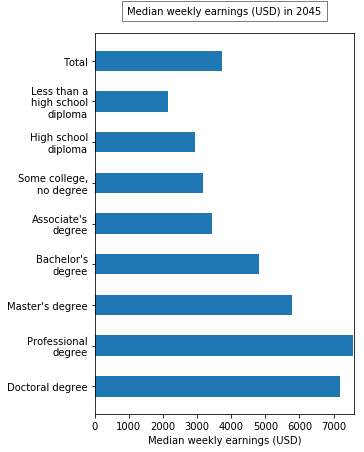

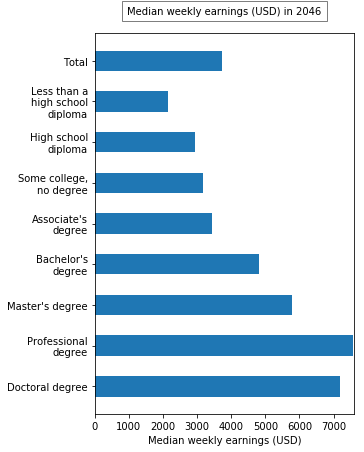

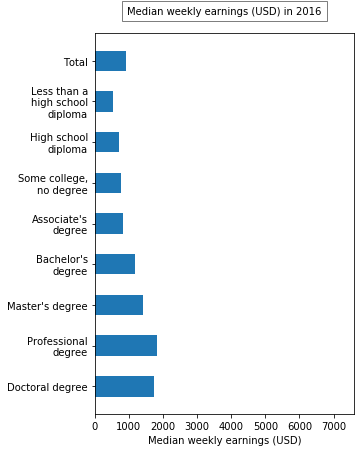

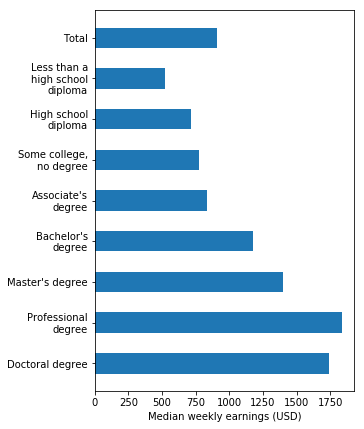

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import textwrap  # Standard library for text wraping
import requests
import pandas as pd
from bs4 import BeautifulSoup


# Specify the url
url = "https://www.bls.gov/emp/ep_table_001.htm"

# Query the website and get the html response
response = requests.get(url)

# Parse the returned html using BeautifulSoup
bs = BeautifulSoup(response.text)

# Select the table header by CSS selector
thead = bs.select("#bodytext > table > thead")[0]

# Select the table body by CSS selector
tbody = bs.select("#bodytext > table > tbody")[0]

# Get the column names
headers = []

# Find all header columns in <thead> as specified by <th> html tags
for col in thead.find_all('th'):
    headers.append(col.text.strip())

# Dictionary of lists for storing parsed data
data = {header:[] for header in headers}

# Parse the rows in table body
for row in tbody.find_all('tr'):
    # Find all columns in a row as specified by <th> or <td> html tags
    cols = row.find_all(['th','td'])
    
    # enumerate() allows us to loop over an iterable, 
    # and return each item preceded by a counter
    for i, col in enumerate(cols):
        # Strip white space around the text
        value = col.text.strip()
        
        # Try to convert the columns to float, except the first column
        if i > 0:
            value = float(value.replace(',','')) # Remove all commas in string
        
        # Append the float number to the dict of lists
        data[headers[i]].append(value)

# Create a dataframe from the parsed dictionary
df = pd.DataFrame(data)

# Create a figure
fig, ax = plt.subplots(figsize=(6,7))

# Create a list of x ticks positions
ind = range(df.shape[0])

# Plot a bar chart of median usual weekly earnings by educational attainments
ax.barh(ind, df["Median usual weekly earnings ($)"], height=0.5)

# Set the x-axis label
ax.set_xlabel('Median weekly earnings (USD)')

# Label the x ticks
# The tick labels are a bit too long, let's wrap them in 15-char lines
ylabels=[textwrap.fill(label,15) for label in df["Educational attainment"]]
ax.set_yticks(ind)
ax.set_yticklabels(ylabels)

# Give extra margin at the bottom to display the tick labels
fig.subplots_adjust(left=0.3)

# Show the figure in a GUI
plt.show()

# Creating animated plot

In [5]:
import textwrap 
import matplotlib.pyplot as plt
import random
# Matplotlib animation module
from matplotlib import animation
# Used for generating HTML video embed code
from IPython.display import HTML


# Adapted from previous example, codes that are modified are commented
fig, ax = plt.subplots(figsize=(6,7))
ind = range(df.shape[0])
rects = ax.barh(ind, df["Median usual weekly earnings ($)"], height=0.5)
ax.set_xlabel('Median weekly earnings (USD)')
ylabels=[textwrap.fill(label,15) for label in df["Educational attainment"]]
ax.set_yticks(ind)
ax.set_yticklabels(ylabels)
fig.subplots_adjust(left=0.3)

# Change the x-axis range
ax.set_xlim(0,7600)

# Add a text annotation to show the current year
title = ax.text(0.5,1.05, "Median weekly earnings (USD) in 2017", 
                bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                transform=ax.transAxes, ha="center")

# Animation related stuff
n=30 #Number of frames

def animate(frame):
    # Simulate 5% annual pay rise 
    data = df["Median usual weekly earnings ($)"] * (1.05 ** frame)

    # Update the bar heights
    for i, rect in enumerate(rects):
        rect.set_width(data[i])
        
    # Update the title
    title.set_text("Median weekly earnings (USD) in {}".format(2017+frame))
    
    return rects, title

# Call the animator. Re-draw only the changed parts when blit=True. 
# Redraw all elements when blit=False
anim=animation.FuncAnimation(fig, animate, blit=False, frames=n)

# Save the animation in MPEG-4 format
anim.save('ch09_animation.mp4')

# OR--Embed the video in Jupyter notebook
HTML(anim.to_html5_video())

In [6]:
import textwrap 
import matplotlib.pyplot as plt
import random
# Matplotlib animation module
from matplotlib import animation
# Used for generating HTML video embed code
from IPython.display import HTML


# Adapted from previous example, codes that are modified are commented
fig, ax = plt.subplots(figsize=(6,7))
ind = range(df.shape[0])
rects = ax.barh(ind, df["Median usual weekly earnings ($)"], height=0.5)
ax.set_xlabel('Median weekly earnings (USD)')
ylabels=[textwrap.fill(label,15) for label in df["Educational attainment"]]
ax.set_yticks(ind)
ax.set_yticklabels(ylabels)
fig.subplots_adjust(left=0.3)

# Change the x-axis range
ax.set_xlim(0,7600)

# Add a text annotation to show the current year
title = ax.text(0.5,1.05, "Median weekly earnings (USD) in 2016", 
                bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                transform=ax.transAxes, ha="center")

# Animation related stuff
n=30 #Number of frames

def animate(frame):
    # Simulate 5% annual pay rise 
    data = df["Median usual weekly earnings ($)"] * (1.05 ** frame)

    # Update the bar heights
    for i, rect in enumerate(rects):
        rect.set_width(data[i])
        
    # Update the title
    title.set_text("Median weekly earnings (USD) in {}".format(2016+frame))
    
    return rects, title

# Call the animator. Re-draw only the changed parts when blit=True. 
# Redraw all elements when blit=False
anim=animation.FuncAnimation(fig, animate, blit=False, frames=n)

# Save the animation as animated GIF
anim.save('test.gif', writer='imagemagick', fps=30)